# TUTORIAL 3 - A FEEDFORWARD SPIKING NEURAL NETWORK

In this tutorual, we will:
* Simplify the leaky integrate-and-fire (LIF) neuron model to make it deep learning-friendly.
* Implement a feedforward spiking neural network (SNN).

# 1. SIMPLIFING THE LEAKY INTEGRATE-AND-FIRE NEURON MODEL
In the previous tutorial, we designed our own LIF neuron model. However, it is quite complex and an array of hyperparameters to tune: $R, C, \Delta t, U_{thres}$, and the choice of the reset mechanism (`zero` or `subtraction`). These are a lot of paramters to tune for just one neuron. To make it more deep learning-friendly, we are going to simplify the model.
Skiping here the full derivation (can be found at [snnTorch tutorial 3](https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_3.html)), we intorduce the following model:

$$
\begin{align}
    U[t+1] = \beta U[t] + WX[t+1] - S[t]U_{thres}
\end{align}
$$

1. **The decay rate - $\beta$**: represents the "leaky" part and factors the previou step. $\beta = (1-\frac{\Delta t}{\tau})$. Assume $\Delta t << \tau$, 
  
2. **The weighted input curret $W$**: A learnable parameter. Weights the input current (spike train) at the current input to the neuron (the inegrate part).
3. **Spiking and reset**: Sutract the threshold from the membrane potential.
   $$
   \begin{align}
       S[t] = \begin{cases}
           1 & \text{if } U[t] > U_{thres} \\
           0 & \text{otherwise}
       \end{cases}
   \end{align}
   $$

## 1.1 CODE IMPLEMENTATION

In [12]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [13]:
def leaky_integrate_and_fire(Umem, X, W, beta, thres=1):
    """
    Simplified leaky integrate-and-fire neuron model.
    
    Args:
        Umem (float): Membrane potential.
        x (float): Input spike.
        w (float): Weight of the synapse.
        beta (float): Decay factor for the membrane potential.
        thres (int, optional): Threshold for spike generation. Defaults to 1.
    
    Returns:
        tuple: Updated membrane potential and spike output.
    """
    spk = (Umem > thres)
    Umem = beta*Umem + W*X - spk*thres
    return spk, Umem

How can we set the value of $\beta$? In the future, we are just going to set it as a hyper paremeter. But now, for the sake of gaining intuition, we can use the relation of the exponential decay of the membrane potential:
$$ 
U(t+\Delta t) = \beta U(t) \\
U(t+\Delta t) = e^{-\frac{t+\Delta t}{\tau}} \\
\implies \beta = \frac{U(t+\Delta t)}{U(t)} = e^{-\frac{\Delta t}{\tau}} \\
$$


In [14]:
# set parameters:
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t / tau)

print(f"The decay rate is: {beta.item():.3f}")

The decay rate is: 0.819


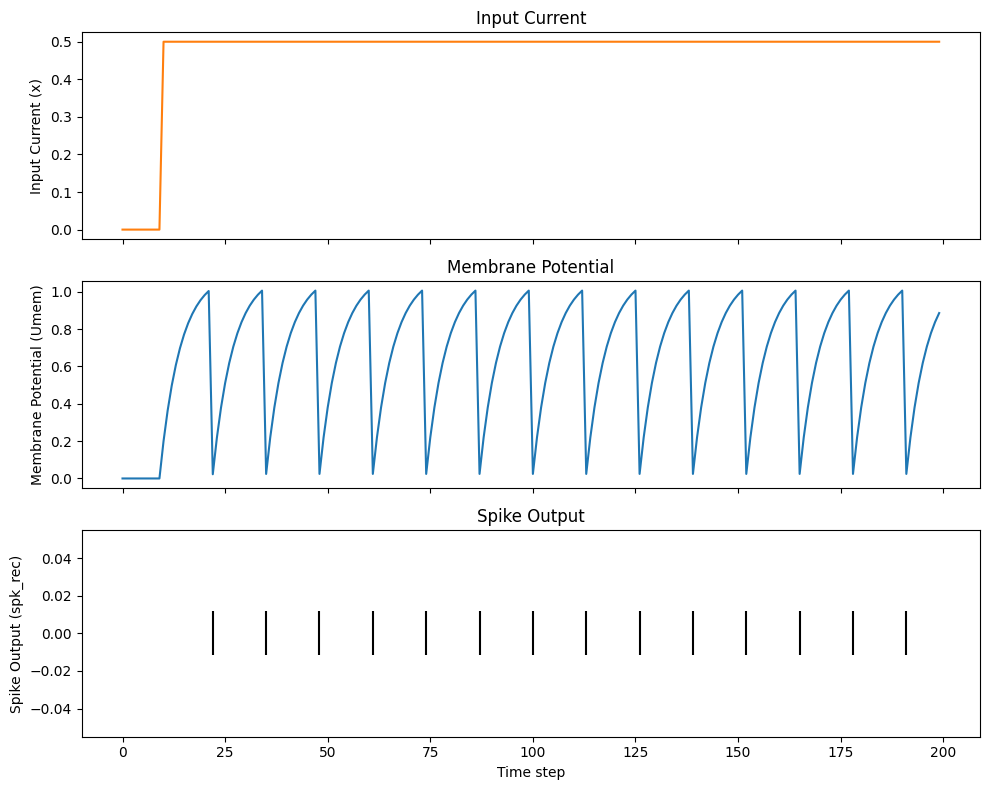

In [15]:
# Lets check how the neurons behave ti a step voltage input

num_steps = 200
# initializine inputs and outputs + a small step current input

x = torch.zeros(num_steps)
x[10:] = 0.5
Umem = torch.zeros(1)
spk_out = torch.zeros(1)
Umem_rec = []
spk_rec = []

# Neuron Parameters:
w = 0.4
beta = 0.819

# Neuron simulation loop
for step in range(num_steps):
    spk, Umem = leaky_integrate_and_fire(Umem, x[step], W=w, beta=beta)
    Umem_rec.append(Umem.item())
    spk_rec.append(spk.item())

# convert lists to tensors
Umem_rec = torch.tensor(Umem_rec)
spk_rec = torch.tensor(spk_rec)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Input current
axs[0].plot(x, color='tab:orange')
axs[0].set_ylabel('Input Current (x)')
axs[0].set_title('Input Current')

# Membrane potential
axs[1].plot(Umem_rec, color='tab:blue')
axs[1].set_ylabel('Membrane Potential (Umem)')
axs[1].set_title('Membrane Potential')

# Spike output
splt.raster(spk_rec, ax=axs[2], s=1000, c="black", marker="|")
axs[2].set_ylabel('Spike Output (spk_rec)')
axs[2].set_xlabel('Time step')
axs[2].set_title('Spike Output')

plt.tight_layout()
plt.show()


# 2. LEAKY NEURON MODEL IN SNNTORCH
The same functionality can be implemented in snnTorch using the `snn.Leaky` class. 

In [16]:
lif1 = snn.Leaky(beta=0.8)

Now, we will repeat the same steps as in the previous section. Every step, the input current is multiplied by the weight $W$, 

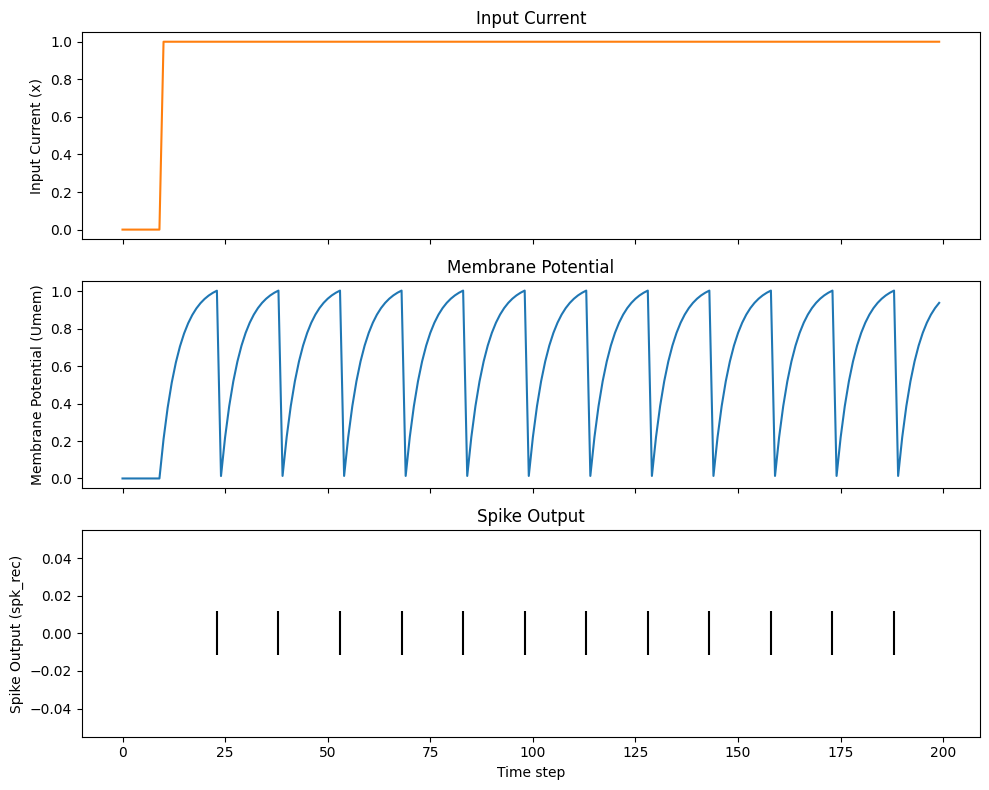

In [17]:
# Lets check how the neurons behave ti a step voltage input

num_steps = 200
# initializine inputs and outputs + a small step current input

x = torch.zeros(num_steps)
x[10:] = 1
Umem = torch.zeros(1)
spk_out = torch.zeros(1)
Umem_rec = []
spk_rec = []

# Neuron Parameters:
w = 0.21

# Neuron simulation loop
for step in range(num_steps):
    spk, Umem = lif1(w*x[step], Umem)
    Umem_rec.append(Umem.item())
    spk_rec.append(spk.item())

# convert lists to tensors
Umem_rec = torch.tensor(Umem_rec)
spk_rec = torch.tensor(spk_rec)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Input current
axs[0].plot(x, color='tab:orange')
axs[0].set_ylabel('Input Current (x)')
axs[0].set_title('Input Current')

# Membrane potential
axs[1].plot(Umem_rec, color='tab:blue')
axs[1].set_ylabel('Membrane Potential (Umem)')
axs[1].set_title('Membrane Potential')

# Spike output
splt.raster(spk_rec, ax=axs[2], s=1000, c="black", marker="|")
axs[2].set_ylabel('Spike Output (spk_rec)')
axs[2].set_xlabel('Time step')
axs[2].set_title('Spike Output')

plt.tight_layout()
plt.show()


# 3. A FEEDFORWARD SPIKING NERUAL NETWORK
So far, we have only considered how to implement a single neuron, and concentrated on its response to stimulus. Using `ssnTorch` and `PyTorch` it is straightforward to scale this into a deep neural network. In the following section we will create a 3-layer feedforward fully-connected neural network of dimensions 784-1000-10. In contrary to previous tutorials, now each neuron will integrate over many more incoming input spikes. Each scaled by a learnable weight, given from a `PyTorch` function.
It is important to note the format of the data is:
$$
\begin{align}
    [time\_steps \times  batch\_size \times features\_size]
\end{align}
$$

In [ ]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10

beta = 0.99
time_steps = 200
batch_size = 1

# initialize layers:
fc1 = nn.Linear(num_inputs, num_hidden)     # Pytorch - these are learnable connection weights
lif1 = snn.Leaky(beta=beta)                 # SNN layer - Activation function with a leaky spiking neuron model
fc2 = nn.Linear(num_hidden, num_outputs)    # Pytorch - these are learnable connection weights
lif2 = snn.Leaky(beta=beta)                 # SNN layer - Activation function with a leaky spiking neuron model

# initialize the network
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

In [19]:
# the input layer:
spk_in = spikegen.rate_conv(torch.rand(time_steps, num_inputs)) # [time_steps, num_inputs]
print(f"Input spikes shape: {spk_in.shape}")
spk_in = spk_in.view(time_steps, batch_size, num_inputs)  # [time_steps, batch_size, num_inputs]
print(f"Input spikes reshaped: {spk_in.shape}")

Input spikes shape: torch.Size([200, 784])
Input spikes reshaped: torch.Size([200, 1, 784])


Now we can run the simulation. Remeber, the connections (here are `nn.Linear`) are the learned weights, multiplying each input to the neuron. The output of each neuron is a spike train.

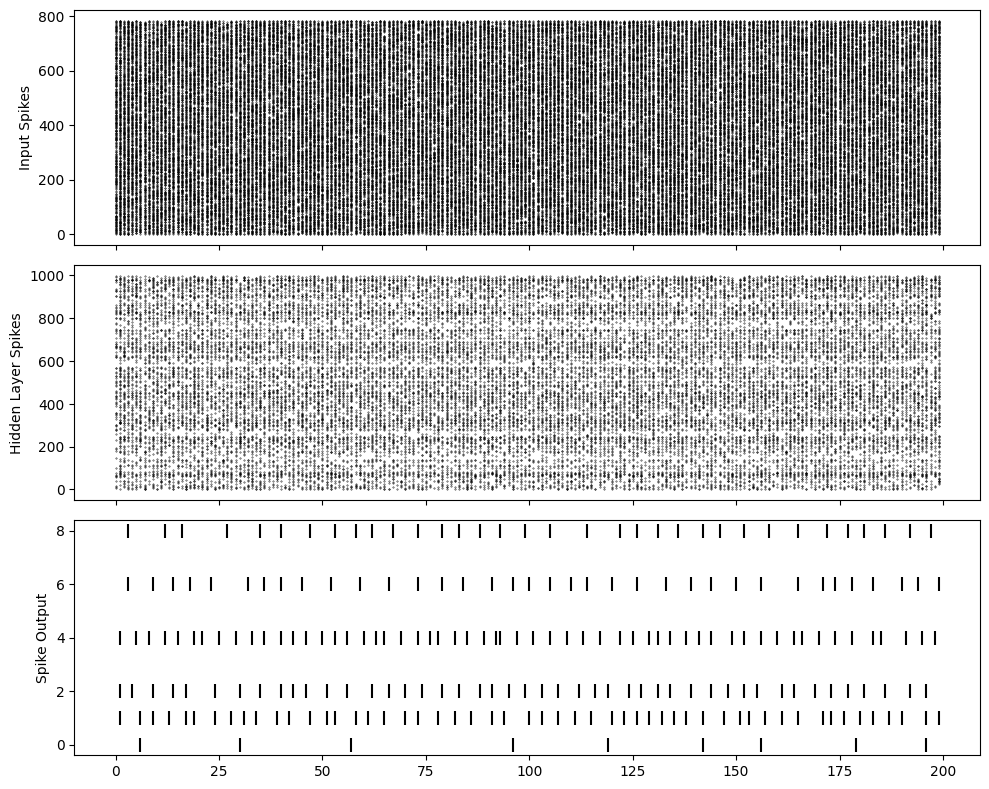

In [35]:
# record the outputs
mem1_rec = []
mem2_rec = []
spk1_rec = []
spk2_rec = []

# Neuron simulation loop
for step in range(num_steps):
    cur1 = fc1(spk_in[step])  # [batch_size, num_hidden]
    spk1, mem1 = lif1(cur1, mem1)  # [batch_size, num_hidden]

    cur2 = fc2(spk1)  # [batch_size, num_outputs]
    spk2, mem2 = lif2(cur2, mem2)  # [batch_size, num_outputs]

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)


# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

# Plotting raster plots
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# spk_in
splt.raster(spk_in.squeeze(1), axs[0], c="black", s=0.1)
axs[0].set_ylabel('Input Spikes')

# Hidden layer spikes
splt.raster(spk1_rec.squeeze(1), ax=axs[1], c="black", s=0.1)
axs[1].set_ylabel('Hidden Layer Spikes')

# Spike output
splt.raster(spk2_rec.squeeze(1), ax=axs[2], c="black", s=100, marker="|")
axs[2].set_ylabel('Spike Output')

plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")